<a href="https://colab.research.google.com/github/xslittlemaggie/Deep-Learning-Machine-Learning-Projects/blob/master/car_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 0: Import libraries

In [0]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [0]:
% matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import cv2
import os

#### 0.1 visuzalize the segmentation image

In [0]:
os.mkdir("/content/CameraRGB/")
os.mkdir("/content/CameraSeg/")

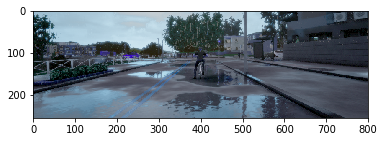

In [27]:
plt.imshow(RGB_img_array)

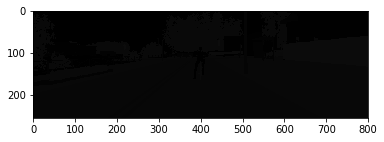

In [29]:
plt.imshow(Seg_img_array)

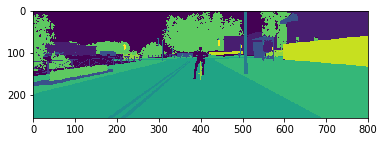

In [36]:
plt.imshow(Seg_img_array[:,:,0])

## Step1: Upload data from google drive to colab

In [22]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
# !ls "/content/drive/My Drive"

## Step 1: Get familar with the data & visualize the images

#### 1.1 visualize one image with the corresponding labelled image

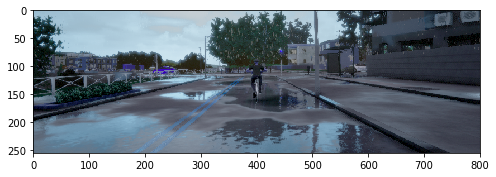

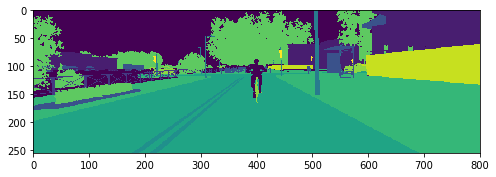

In [53]:
#fig = plt.figure(figsize = (8, 6))
img_RGB = "/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/episode_0000/CameraRGB/000020.png"
img_Seg = "/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/episode_0000/CameraSeg/000020.png"
img_RGB_arary = cv2.imread(img_RGB)
img_Seg_arary = cv2.imread(img_Seg)
plt.rcParams['figure.figsize'] = (8, 6)
plt.imshow(img_RGB_arary)
plt.show()
plt.imshow(img_Seg_arary[:, :, 0])
plt.show() 
 

In [97]:
#
x_train = []
i = 0
for img in os.listdir("/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/episode_0000/CameraRGB"):
  img_path = os.path.join("/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/episode_0000/CameraRGB", img)
  img_array = cv2.imread(img_path)
  #print(img_array)
  x_train.append(img_array/255)
    
#new_array = cv2.resize(img_array, (img_size, img_size))
  

x_train = np.asarray(x_train)
x_train.shape

(180, 256, 800, 3)

## Step 2: Prepare for the U-Net Model

In [101]:
y_train = []
i = 0
for img in os.listdir("/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/episode_0000/CameraSeg"):
  img_path = os.path.join("/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/episode_0000/CameraSeg", img)
  img_array = cv2.imread(img_path)
  y_train.append(img_array[:, :, 0:1])
y_train = np.asarray(y_train)
y_train.shape

(180, 256, 800, 1)

In [0]:
# !rm "/content/drive/My Drive/Deep Learning projects/car segmentation/training data part/episode_0000/CameraSeg/._000020.png"

A successful and popular model for object detection if the UNet architecture. It consists of a contracting path and an expansive path.

The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3 * 3 convolutions, each followed by a batchnormalization layer and a ReLU activation and dropout and a 2 * 2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channnels. THe purpose of this contracting path is to capture the context of the input image in order to be able to do segmentation.

Every step in the expansive path consists of an upsampling of the feature map followed by a 2 * 2 convolution ("up-convolution") that halves the number of feature channels, a concatenation with the correspondingly feature map from the contracting path, and two 3 * 3 convolutions, each followed by batchnorm, dropout and a ReLU. The purpose of this expanding path is to enable precise localization combined with contextual information from the contracting path.

At the final layer a 1 * 1 convolution is used to map each 16 - component feature vector to the desired number of classes.

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [0]:


def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [12]:
im_height = 256
im_width = 800

input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

W0805 06:59:54.468653 139929640736640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 06:59:54.501146 139929640736640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 06:59:54.504290 139929640736640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0805 06:59:54.536432 139929640736640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0805 06:59:54.537702

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 800, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 800, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 800, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 800, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
from keras.utils import plot_model
plot_model(model) # to_file='model.png'

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [1]:
results = model.fit(x_train, y_train, batch_size=32, epochs=1, callbacks=callbacks)
# validation_data=(x_valid, y_valid)

NameError: ignored

Using TensorFlow backend.


NameError: ignored

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

## Step 3: Training

## Step 4: Inference With the Model

In [0]:
# Load best model
model.load_weights('model-tgs-salt.h5')

In [0]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

In [0]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

## Useful reference
URL_1 = "https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a"

URL_2 = "https://tryolabs.com/blog/2018/01/18/faster-r-cnn-down-the-rabbit-hole-of-modern-object-detection/"

URL_3 = "https://tryolabs.com/blog/2017/08/30/object-detection-an-overview-in-the-age-of-deep-learning/" **(include datasets)**

URL_4 = "https://tryolabs.com/blog/2018/01/18/faster-r-cnn-down-the-rabbit-hole-of-modern-object-detection/"

URL_5 = "https://towardsdatascience.com/deep-learning-for-object-detection-a-comprehensive-review-73930816d8d9" **(Deep learning for object Detection)**

URL_6 = "https://towardsdatascience.com/deep-learning-for-object-detection-a-comprehensive-review-73930816d8d9"

URL_7 = "https://www.depends-on-the-definition.com/unet-keras-segmenting-images/" **(unet model)**